# Tutorial 2: Intermediate level
Using esinet to predict single time-frame sources of a sample ERF data set: The Brainstorm Auditory data. 

This tutorial is based on an [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html)

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
import os

subjects_dir = os.path.join(os.path.normpath(mne.datasets.sample.data_path()).replace("\\", "/"), 'subjects')
plot_params = dict(surface='inflated', cortex="low_contrast", hemi='both', verbose=0)
mne.set_config('SUBJECTS_DIR', subjects_dir)

# Load the data
Just as in the [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html) we have to load some sample data first

In [5]:
data_path = os.path.join(os.path.normpath(mne.datasets.sample.data_path()).replace("\\", "/"))
raw_fname = os.path.join(data_path, 'MEG', 'sample',  
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, verbose=0)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
# raw.info['bads'] = ['MEG 2443', 'EEG 053']  # no bad channels with EEG
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, eog=150e-6)  # , mag=4e-12

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=baseline, reject=reject,  # grad instead of meg
                    verbose=0, preload=True)

epochs.drop_channels('EOG 061')
fname_fwd = os.path.join(os.path.normpath(data_path).replace("\\", "/"), "MEG", "sample", "sample_audvis-meg-oct-6-fwd.fif")
fwd = mne.read_forward_solution(fname_fwd, verbose=0)


epochs_stripped = epochs.copy().load_data().pick_types(meg=True) # instead of meg=True
fwd = fwd.pick_channels(epochs_stripped.ch_names)
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                                    use_cps=True, verbose=0)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


## Visualize the sample data

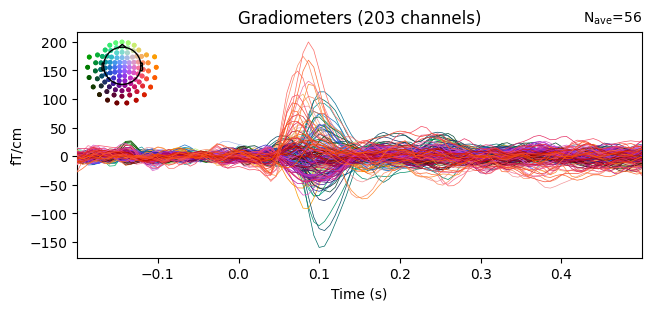

Number of events,56
Events,aud_l: 56
Time range,-0.200 – 0.499 s
Baseline,-0.200 – 0.000 s


In [6]:
epochs.average().plot(verbose=0)
epochs

# Simulate Data
Artificial neural networks need training data to learn how to predict brain-electric activity (sources) given the M/EEG data. 

First, we calculate the signal to noise ratio (SNR) of our EEG data so we can adjust our simulations to it. 

In [7]:
target_snr = util.calc_snr_range(epochs, baseline_span=(-0.2, 0.0), data_span=(0.05, 0.2))
print(f'The target SNR is {target_snr:.2f}')

The target SNR is 4.58


/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/util/util.py:228: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (-0.199795 s)
  data_base = evoked.copy().crop(*baseline_span)._data


Next, we can perform the simulations with the packages default settings. Change n_samples to a smaller integer in case this cell runs for too long. Note, that for publication-ready inverse solutions you should increase the number of training samples to 100,00.

In [9]:
settings = dict(duration_of_trial=0.01, target_snr=target_snr)
n_samples = 1000
simulation = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation.simulate(n_samples=n_samples)

/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/simulation.py:667: RuntimeWarning: 8.5% of original source space vertices have been omitted, tri-based adjacency will have holes.
Consider using distance-based adjacency or morphing data to all source space vertices.
  adj = mne.spatial_src_adjacency(self.fwd["src"], verbose=0).toarray().astype(int)


Simulate Source
Simulating data based on sparse patches.


100%|██████████| 1000/1000 [00:04<00:00, 248.00it/s]


Converting Source Data to mne.SourceEstimate object


100%|██████████| 1000/1000 [00:00<00:00, 54219.40it/s]



Project sources to EEG...

Create EEG trials with noise...


100%|██████████| 1000/1000 [00:01<00:00, 679.52it/s]



Convert EEG matrices to a single instance of mne.Epochs...


## Visualize the simulated data
Let's visualize the simulated data and see if it looks alright. You can change the idx to another integer to visualize a different sample

In [10]:
%matplotlib qt
idx = 0

simulation.eeg_data[idx].average().plot_topomap([0.])
simulation.source_data[idx].plot(**plot_params, initial_time=simulation.source_data[idx].times[idx], time_viewer=False)

# Train the Neural Network
The Net class contains our neural network.

Using the simulations created above, we can train the neural network. This may take a few minutes, depending on your PC.
For best results you should increase the number of epochs to 100 or more.  

In [11]:
model_type = 'FC'  # can be 'LSTM' or 'ConvDip', too
net = Net(fwd, verbose=1, model_type=model_type)  # Initialize the neural network object
net.fit(simulation, epochs=10)  # Train the net using our simulated eeg and source data.

preprocess data


Model: "FC_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_FC (InputLayer)           │ (None, None, 203)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC_0 (TimeDistributed)          │ (None, None, 200)      │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_0 (Dropout)                │ (None, None, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC_Out (TimeDistributed)        │ (None, None, 7498)     │     1,507,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,547,898 (5.90 MB)

 Trainable params: 1,547,898 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

fit model
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.0935 - val_loss: -0.2383
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.2443 - val_loss: -0.2909
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.2759 - val_loss: -0.3141
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.2965 - val_loss: -0.3207
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.3092 - val_loss: -0.3398
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.3324 - val_loss: -0.3391
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.3447 - val_loss: -0.3359
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.3369 - val_loss: -0.3454
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.3523 - val_loss: -0.3557
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.3576 - val_loss: -0.3603


# Evaluate the ANN
The evaluation is a two-step procedure. 
1. Simulate some test data which the neural network has not seen yet. Unlike 
   the training data, this simulated data will also have a temporal dimension, 
   as indicated by the "duration_of_trial" parameter.

2. Perform predicions on this data and visually examine the results.

In [12]:
settings = dict(duration_of_trial=0.02, target_snr=target_snr, number_of_sources=(1, 10), extents=(2, 40),)
n_samples = 10
simulation_test = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation_test.simulate(n_samples=n_samples)


# Predict source from EEG
source_hat = net.predict(simulation_test)

/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/simulation.py:667: RuntimeWarning: 8.5% of original source space vertices have been omitted, tri-based adjacency will have holes.
Consider using distance-based adjacency or morphing data to all source space vertices.
  adj = mne.spatial_src_adjacency(self.fwd["src"], verbose=0).toarray().astype(int)


Simulate Source
Simulating data based on sparse patches.


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Converting Source Data to mne.SourceEstimate object


100%|██████████| 10/10 [00:00<00:00, 14518.19it/s]



Project sources to EEG...

Create EEG trials with noise...


100%|██████████| 10/10 [00:00<00:00, 259.79it/s]


Convert EEG matrices to a single instance of mne.Epochs...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/net.py:1081: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  opt = minimize_scalar(self.correlation_criterion, args=(self.leadfield, y_est* base_scaler, x_true), \


Residual Variance(s): [19.79, 5.67, 15.68, 6.81, 7.57, 6.61, 2.73, 11.76, 8.83, 13.52] [%]


Visualize a sample

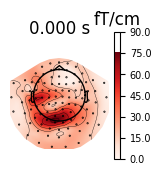

: 

In [ ]:
%matplotlib qt

# Ground Truth
idx = 0
source = simulation_test.source_data[idx]
# Plot simulated Source
a = source.plot(**plot_params)
a.add_text(0.1, 0.9, 'Gound Truth', 'title',
               font_size=14)
# Plot simulated EEG
evoked = simulation_test.eeg_data[idx].average()
evoked.plot()
evoked.plot_topomap([0.0,])

# Plot esinet prediction
b = source_hat[idx].plot(**plot_params)
b.add_text(0.1, 0.9, 'Prediction', 'title',
               font_size=14)

# Plot predicted EEG
evoked_hat = util.get_eeg_from_source(source_hat[idx], fwd, epochs_stripped.info, tmin=0)
evoked_hat.plot()
evoked_hat.plot_topomap([0.0,])

# Estimate sources from real data
Using ANN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/net.py:1081: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  opt = minimize_scalar(self.correlation_criterion, args=(self.leadfield, y_est* base_scaler, x_true), \


Residual Variance(s): [19.82] [%]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


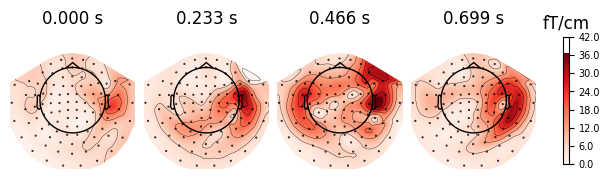

Using control points [1.24517314e-10 1.42763367e-10 2.22497479e-10]


In [16]:
# Predict Source
stc = net.predict(epochs.average())[0]
# Plot Predicted Source
brain = stc.plot(**plot_params)
brain.add_text(0.1, 0.9, 'esinet on Auditory Data', 'title',
               font_size=14)
# Plot true EEG
epochs.load_data()

epochs.pick(["meg",]).average().plot()
epochs.pick(["meg",]).average().plot_topomap()

# Plot predicted EEG
evoked_esi = util.get_eeg_from_source(stc, fwd, epochs.pick_types(meg=True).info, tmin=0.)
evoked_esi.plot()
evoked_esi.plot_topomap()


...using eLORETA

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


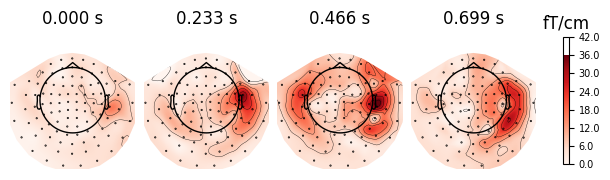

Using control points [5.73961917e-11 6.52663081e-11 1.05686059e-10]


In [17]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=False)

inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked.info, fwd, noise_cov, loose='auto', depth=None, fixed=True, 
    verbose=False)
    
stc_elor, residual = mne.minimum_norm.apply_inverse(epochs.average(), inverse_operator, lambda2,
                              method=method, return_residual=True, verbose=False)
brain = np.abs(stc_elor).plot(**plot_params)
brain.add_text(0.1, 0.9, 'eLORETA on auditory data', 'title',
               font_size=14)
# Plot predicted EEG
epochs.load_data()
evoked_elor = util.get_eeg_from_source(stc_elor, fwd, epochs.pick_types(meg=True).info, tmin=0.)
evoked_elor.plot()
evoked_elor.plot_topomap()
